!pip install sklearn

# Part-of-speech tagging

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pickle
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from collections import OrderedDict
from keras.preprocessing.text import Tokenizer

import re
from functools import reduce
import nltk
from nltk.corpus import stopwords
from typing import List, Callable, Dict
from nltk.stem import WordNetLemmatizer


### Define constant variables

In [2]:
train_path = './Dataset/train/'# Should we use: os.path.join(os.getcwd(), "OriginalDataset")
val_path = './Dataset/val/'
test_path = './Dataset/test/'
dataset_folder = os.path.join(os.getcwd(), "OriginalDataset")
original_path = dataset_folder +'/dependency_treebank/'

embedding_dimension = 50


### Download dataset

In [3]:
import urllib.request  #  download files
import zipfile  #  unzip files

def download_dataset():
    dataset_folder = os.path.join(os.getcwd(), "OriginalDataset")

    if not os.path.exists(dataset_folder):
        os.makedirs(dataset_folder)

    url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

    dataset_path = os.path.join(dataset_folder, "dependency_treebank.zip")

    if not os.path.exists(dataset_path):
        urllib.request.urlretrieve(url, dataset_path)
        print("Successful download")

    with zipfile.ZipFile(dataset_path,"r") as zip_ref:
        zip_ref.extractall(dataset_folder)
    print("Successful extraction")

In [4]:
# Uncomment to download dataset
# download_dataset()

### Split dataset

In [5]:
def split_dataset(train_path, val_path, test_path, original_path):
    if not os.path.exists(train_path):
        print("making directory")
        os.makedirs(train_path)
    if not os.path.exists(val_path):
        os.makedirs(val_path)
    if not os.path.exists(test_path):
        os.makedirs(test_path)

    original_dataset = os.listdir(original_path)
    
    original_dataset.sort()
    org_train = original_dataset[0:100]
    org_val = original_dataset[100:150]
    org_test = original_dataset[150:]

    for f in org_train:
        os.rename(original_path+f, train_path+f)
    for f in org_val:
        os.rename(original_path+f, val_path+f)
    for f in org_test:
        os.rename(original_path+f, test_path+f)
    print("Successful spilt")
        

In [6]:
# Uncomment the following line to split the dataset
# split_dataset(train_path, val_path, test_path, original_path)


### Create dataframe

In [7]:
def create_dataframe(dataset_path: str):
    dataframe_rows = []
    documents = os.listdir(dataset_path)
    for document in documents:
        path = os.path.join(dataset_path, document)
        with open(path, 'r') as f:
            a = [[x for x in ln.split()] for ln in f]
        #---------------For splitting on sentence-------------------#
        sentence = []
        sentence_tag = []
        for x in a:
            if x!=[]:
                sentence.append(x[0])
                sentence_tag.append(x[1])
            else:
                dataframe_row = {
                    "text": sentence,
                    "POS": sentence_tag
                }
                sentence = []
                sentence_tag = []
                dataframe_rows.append(dataframe_row)
        #----------------------------------------------------------#
        #------------------To split on document--------------------#
        """
        a2 = [x for x in a if x != []] # OBS! Removing all empty lines in file so we can make an array
        arr = np.array(a2)
        text = list(arr[:, 0])
        tagg = list(arr[:, 1])
        #POStuple =  [tagg[x] for x in range(len(text))] #[(text[x], tagg[x]) for x in range(len(text))]
        document_id = int(document[4:8])
        dataframe_row = {
            "document_id": document_id,
            "text": text,
            "POS": tagg
        }
        dataframe_rows.append(dataframe_row)"""
        #----------------------------------------------------------#
    # transform the list of rows in a proper dataframe
    df = pd.DataFrame(dataframe_rows)
    df = df[["text", "POS"]]

    return df

In [8]:
df_train = create_dataframe(train_path)
df_val = create_dataframe(val_path)
df_test = create_dataframe(test_path)

# Clean data

# OBS REMOVE UNUSED FUNCTIONS

In [9]:
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

REPLACE_BY_SPACE_RE = re.compile("[/(){}\[\]\|@,;]")
GOOD_SYMBOLS_RE = re.compile("[^0-9a-z #+_$]")
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))



def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """

    return text.lower()

def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return REPLACE_BY_SPACE_RE.sub('', text)

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """

    return GOOD_SYMBOLS_RE.sub('', text)

def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])

def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    Example:
    Input: '  This assignment is cool\n'
    Output: 'This assignment is cool'
    """

    return text.strip()    

def lemmatize_words(text: str ) -> str:
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

PREPROCESSING_PIPELINE = [
                          lower,
                          replace_special_characters,
                          filter_out_uncommon_symbols,
                          ]

def text_prepare(text,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """

    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE

    new_row = [reduce(lambda txt, f: f(txt), filter_methods, x) for x in text]
    return [x for x in new_row if x!='']


# Replace each sentence with its pre-processed version
df_train['text'] = df_train['text'].apply(lambda txt: text_prepare(txt))
df_train['POS'] = df_train['POS'].apply(lambda txt: text_prepare(txt))
df_val['text'] = df_val['text'].apply(lambda txt: text_prepare(txt))
df_val['POS'] = df_val['POS'].apply(lambda txt: text_prepare(txt))
df_test['text'] = df_test['text'].apply(lambda txt: text_prepare(txt))
df_test['POS'] = df_test['POS'].apply(lambda txt: text_prepare(txt))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/solveig.mohr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Embed the words using GloVe embedding

#### Load glove model

In [10]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [11]:
embedding_model = load_embedding_model(embedding_dimension)

### NEW WAY TO Make tokenizer

In [12]:
def make_tokenizer(*vocabulary):
    # OBS: The tokenizer removes every word with a special character. Etc: 100,000, $, u.s.
    # The tokenizer also handles OOV terms and when adding more words, it will just add the OOV words to the word to index dictionary. 
    #tokenizer = Tokenizer(oov_token='PAD', filters='!"#%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
    tokenizer = Tokenizer(filters='!"#%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

    
    # UNCOMMENT IF WE WANT TO INCLUDE GOLVE vocabualry
    for v in vocabulary:
        v2 = sum(v.to_numpy().flatten(), [])
        tokenizer.fit_on_texts(v2)
    return tokenizer 


In [13]:
word_tokenizer = make_tokenizer(df_train["text"], df_val["text"], df_test["text"])
tag_tokenizer = make_tokenizer(df_train["POS"])

### Encode X and Y

In [14]:
x_encoded_train = word_tokenizer.texts_to_sequences(df_train["text"])
y_encoded_train = tag_tokenizer.texts_to_sequences(df_train["POS"])

In [15]:
x_encoded_val = word_tokenizer.texts_to_sequences(df_val["text"])
y_encoded_val = tag_tokenizer.texts_to_sequences(df_val["POS"])

In [16]:
x_encoded_test = word_tokenizer.texts_to_sequences(df_test["text"])
y_encoded_test = tag_tokenizer.texts_to_sequences(df_test["POS"])

### Pad encoded sequences

In [17]:
def pad_idx_seqs(idx_seqs, max_seq_len):
    # Keras provides a convenient padding function; 
    padded_idxs = pad_sequences(sequences=idx_seqs, maxlen=max_seq_len, padding="post")
    return padded_idxs

In [18]:
def find_max_length(seqs):
    max_len = 0
    for seq in seqs:
        if len(seq) > max_len:
            max_len = len(seq)
    return max_len

In [19]:
MAX_LENGTH = find_max_length(x_encoded_train)

In [20]:
x_padded_train = pad_idx_seqs(x_encoded_train, MAX_LENGTH)
y_padded_train = pad_idx_seqs(y_encoded_train, MAX_LENGTH)

In [21]:
x_padded_val = pad_idx_seqs(x_encoded_val, MAX_LENGTH)
y_padded_val = pad_idx_seqs(y_encoded_val, MAX_LENGTH)

In [22]:
x_padded_test = pad_idx_seqs(x_encoded_test, MAX_LENGTH)
y_padded_test = pad_idx_seqs(y_encoded_test, MAX_LENGTH)

# NEW METHODE TO GET WORD TO INDX

In [23]:
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

word2idx = word_tokenizer.word_index
idx2word = word_tokenizer.index_word

In [24]:
tag2idx = tag_tokenizer.word_index
idx2tag = tag_tokenizer.index_word

In [25]:
TAG_VOCABULARY_SIZE = len(tag2idx) + 1

### Create embedding matrix

In [26]:
# OBS Computes the OOV with random embeddings
def create_embedding_matrix(embedding_model, embedding_dimension, word_to_idx):
    embedding_matrix = np.zeros((len(word_to_idx)+1, embedding_dimension), dtype=np.float32)
    #embedding_matrix = np.zeros((len(word_to_idx), embedding_dimension), dtype=np.float32)
    for word, idx in word_to_idx.items():
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector
                                
    return embedding_matrix                             

In [27]:
embedding_matrix = create_embedding_matrix(embedding_model, embedding_dimension, word2idx)

#### Define x train and y train

In [28]:
x_train = x_padded_train
y_train = to_categorical(y_padded_train)

In [29]:
x_val = x_padded_val
y_val = to_categorical(y_padded_val, num_classes=TAG_VOCABULARY_SIZE)

In [30]:
x_test = x_padded_test
y_test = y_padded_test
y_test_cate = to_categorical(y_padded_test, num_classes=TAG_VOCABULARY_SIZE)

### Define plotting functions

In [31]:
def plot_accuracy(model_callback):
    plt.plot(model_callback.history['acc'])
    plt.plot(model_callback.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()
    
def plot_loss(model_callback):
    plt.plot(model_callback.history['loss'])
    plt.plot(model_callback.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()

### Define metrics

In [32]:
from keras import backend as K

def recall_m(y_true, y_pred):
    y_true = y_true * K.cast((y_true != 0), 'float32') 
    y_pred = y_pred * K.cast((y_true != 0), 'float32') 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = y_true * K.cast((y_true != 0), 'float32') 
    y_pred = y_pred * K.cast((y_true != 0), 'float32') 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    y_true = y_true * K.cast((y_true != 0), 'float32') 
    y_pred = y_pred * K.cast((y_true != 0), 'float32') 
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Create baseline model

##### two layers architecture: a Bidirectional LSTM layer and a Dense/Fully-Connected layer on top


https://www.kaggle.com/tanyadayanand/pos-tagging-using-rnn/notebook

Not sure about the parameters etc.. but at least it works to train the model

In [33]:
def create_baseline_model(units_LSTM, activation):
    bidirect_model = keras.Sequential()
    bidirect_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable = False,
                                 mask_zero = True
                                ))
    bidirect_model.add(layers.Bidirectional(layers.LSTM(units_LSTM, return_sequences=True)))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    bidirect_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return bidirect_model

In [34]:
baseline_model = create_baseline_model(64, 'softmax')
baseline_model.summary()

2021-12-02 11:13:05.974833: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 186, 50)           526000    
                                                                 
 bidirectional (Bidirectiona  (None, 186, 128)         58880     
 l)                                                              
                                                                 
 dense (Dense)               (None, 186, 40)           5160      
                                                                 
Total params: 590,040
Trainable params: 64,040
Non-trainable params: 526,000
_________________________________________________________________


In [35]:
baseline_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc"])
baseline_training = baseline_model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=25,  epochs=10)

Epoch 1/10
75/75 [==============================] - 22s 185ms/step - loss: 0.0026 - mae: 0.0463 - acc: 0.2163 - val_loss: 0.0024 - val_mae: 0.0434 - val_acc: 0.3268
Epoch 2/10
75/75 [==============================] - 12s 166ms/step - loss: 0.0022 - mae: 0.0396 - acc: 0.4034 - val_loss: 0.0020 - val_mae: 0.0362 - val_acc: 0.4719
Epoch 3/10
75/75 [==============================] - 15s 196ms/step - loss: 0.0018 - mae: 0.0332 - acc: 0.5356 - val_loss: 0.0017 - val_mae: 0.0309 - val_acc: 0.5755
Epoch 4/10
75/75 [==============================] - 12s 164ms/step - loss: 0.0015 - mae: 0.0285 - acc: 0.6196 - val_loss: 0.0015 - val_mae: 0.0275 - val_acc: 0.6226
Epoch 5/10
75/75 [==============================] - 10s 138ms/step - loss: 0.0014 - mae: 0.0256 - acc: 0.6600 - val_loss: 0.0014 - val_mae: 0.0254 - val_acc: 0.6525
Epoch 6/10
75/75 [==============================] - 14s 189ms/step - loss: 0.0013 - mae: 0.0237 - acc: 0.6861 - val_loss: 0.0013 - val_mae: 0.0243 - val_acc: 0.6683
Epoch 7/10

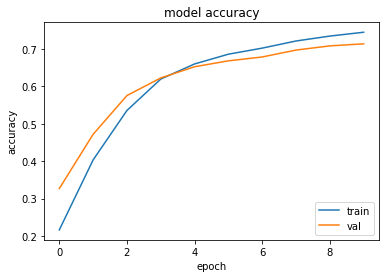

In [36]:
plot_accuracy(baseline_training)

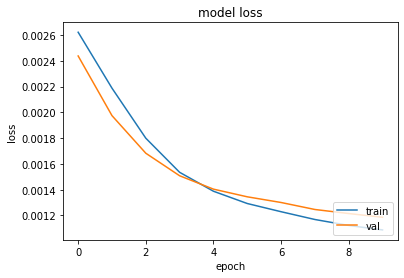

In [37]:
plot_loss(baseline_training)

In [38]:
baseline_model.save_weights('models/baseline_model_weights.h5') #Save model

## Other models

#### Gru

In [377]:
def create_gru_model(units_gru, activation):
    gru_model = keras.Sequential()
    gru_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable = False
                                ))
    gru_model.add(layers.Bidirectional(layers.GRU(units_gru, return_sequences=True)))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    gru_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return gru_model

In [378]:
gru_model = create_gru_model(64, 'softmax')
gru_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 186, 50)           526050    
                                                                 
 bidirectional_10 (Bidirecti  (None, 186, 128)         44544     
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 186, 41)           5289      
                                                                 
Total params: 575,883
Trainable params: 49,833
Non-trainable params: 526,050
_________________________________________________________________


In [379]:
gru_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc", recall_m, precision_m, f1_m])
gru_training = gru_model.fit(x=x_train, batch_size=25, y=y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
75/75 [==============================] - 22s 236ms/step - loss: 0.0115 - mae: 0.0238 - acc: 0.8983 - recall_m: 0.4850 - precision_m: 0.5867 - f1_m: 0.5167 - val_loss: 0.0025 - val_mae: 0.0053 - val_acc: 0.9138 - val_recall_m: 0.8844 - val_precision_m: 1.0000 - val_f1_m: 0.9386
Epoch 2/10
34/75 [============>.................] - ETA: 5s - loss: 0.0024 - mae: 0.0050 - acc: 0.9214 - recall_m: 0.8859 - precision_m: 1.0000 - f1_m: 0.9395

KeyboardInterrupt: 

In [ ]:
plot_accuracy(gru_training)

In [ ]:
plot_loss(gru_training)

In [ ]:
gru_model.save_weights('models/gru_model_weights.h5') #Save model

#### Two LSTM layers

In [ ]:
def create_doubleLSTM_model(units_LSTM1, units_LSTM2, activation):
    doubleLSTM_model = keras.Sequential()
    doubleLSTM_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable     = False
                                ))
    doubleLSTM_model.add(layers.Bidirectional(layers.LSTM(units_LSTM1, return_sequences=True)))
    doubleLSTM_model.add(layers.Bidirectional(layers.LSTM(units_LSTM2, return_sequences=True)))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    doubleLSTM_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return doubleLSTM_model

In [ ]:
doubleLSTM_model = create_doubleLSTM_model(64, 64, 'softmax')
doubleLSTM_model.summary()

In [ ]:
doubleLSTM_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc", recall_m, precision_m, f1_m])
doubleLSTM_training = doubleLSTM_model.fit(x=x_train, batch_size=25, y=y_train, epochs=10, validation_data=(x_val, y_val))

In [ ]:
plot_accuracy(doubleLSTM_training)

In [ ]:
plot_loss(doubleLSTM_training)

In [ ]:
doubleLSTM_model.save_weights('models/doubleLSTM_model_weights.h5') #Save model

#### Two dense layers

In [ ]:
def create_doubledense_model(units_LSTM, units_dense, activation):
    doubledense_model = keras.Sequential()
    doubledense_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable = False
                                ))
    doubledense_model.add(layers.Bidirectional(layers.LSTM(units_LSTM, return_sequences=True)))
    doubledense_model.add(layers.Dense(units_dense))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    doubledense_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return doubledense_model

In [ ]:
doubleDense_model = create_doubledense_model(64, 64, 'softmax')
doubleDense_model.summary()

In [ ]:
doubleDense_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc", recall_m, precision_m, f1_m])
doubleDense_training = doubleDense_model.fit(x=x_train, batch_size=25, y=y_train, epochs=10, validation_data=(x_val, y_val))

In [ ]:
plot_accuracy(doubleDense_training)

In [ ]:
plot_loss(doubleDense_training)

In [ ]:
doubleDense_model.save_weights('models/doubleDense_model_weights.h5') #Save model

# TESTING SO I DONT HAVE TO SCROLL UP AND DOWN

In [67]:
from keras import backend as K

def recall_m(y_true, y_pred):
    y_true = y_true * K.cast((y_true != 0), 'float32') 
    y_pred = y_pred * K.cast((y_true != 0), 'float32') 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = y_true * K.cast((y_true != 0), 'float32') 
    y_pred = y_pred * K.cast((y_true != 0), 'float32') 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    y_true = y_true * K.cast((y_true != 0), 'float32') 
    y_pred = y_pred * K.cast((y_true != 0), 'float32') 
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [111]:
def create_baseline_model(units_LSTM, activation):
    bidirect_model = keras.Sequential()
    bidirect_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable = False,
                                 mask_zero = True
                                ))
    bidirect_model.add(layers.Bidirectional(layers.LSTM(units_LSTM, return_sequences=True)))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    bidirect_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return bidirect_model

In [112]:
baseline_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc"])
baseline_training = baseline_model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=25,  epochs=10)

Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "/usr/local/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.9/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.9/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.9/site-packages/keras/losses.py", line 1204, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 41 and 40 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential/dense/Softmax, IteratorGetNext:1)' with input shapes: [?,186,41], [?,186,40].


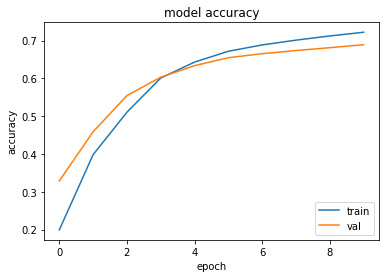

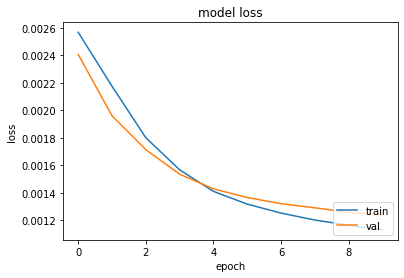

In [ ]:
plot_accuracy(baseline_training)
plot_loss(baseline_training)
baseline_model.save_weights('models/baseline_model_weights.h5') #Save model

## Predict

In [39]:
def predict(model: keras.Model, x, predicting_info):
    predictions = model.predict(x, **predicting_info)
    return predictions

In [40]:
predictions = predict(baseline_model, x_test, {'batch_size': 64})

In [41]:
y_pred_bool = np.argmax(predictions, axis=2)

In [42]:
y_pred_bool[-1]

array([ 4,  1,  3,  4,  2,  2,  2,  9,  1,  3,  9,  5,  3,  1, 11,  4,  6,
        1,  1,  8, 12,  3, 21,  9,  3,  3, 21,  9,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2])

## Evaluate

In [43]:
y_pred_bool = np.argmax(predictions, axis=2)

In [44]:
y_pred_bool.shape

(603, 186)

In [45]:
y_test.shape

(603, 186)

In [46]:
l = list(idx2tag.keys())

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [48]:
all_gold_tags = [tag for sent_tags in y_test for tag in sent_tags]
all_pred_tags = [tag for sent_tags in y_pred_bool for tag in sent_tags]

In [49]:
y_test

array([[ 2,  2,  7, ...,  0,  0,  0],
       [ 2,  5,  7, ...,  0,  0,  0],
       [11,  4,  6, ...,  0,  0,  0],
       ...,
       [ 4,  2,  6, ...,  0,  0,  0],
       [ 4,  1,  8, ...,  0,  0,  0],
       [ 4,  1, 16, ...,  0,  0,  0]], dtype=int32)

In [50]:
y_pred_bool

array([[2, 2, 7, ..., 2, 2, 2],
       [2, 5, 7, ..., 2, 2, 2],
       [3, 4, 2, ..., 2, 2, 2],
       ...,
       [4, 2, 2, ..., 2, 2, 2],
       [4, 1, 8, ..., 2, 2, 2],
       [4, 1, 3, ..., 2, 2, 2]])

In [51]:
indices = [i for i, x in enumerate(all_gold_tags) if x == 0]

In [52]:
new_gold_tags = [x for i, x in enumerate(all_gold_tags) if i not in indices]

In [53]:
new_pred_tags = [x for i, x in enumerate(all_pred_tags) if i not in indices]

In [54]:
new_gold_tags

[2,
 2,
 7,
 15,
 19,
 10,
 4,
 6,
 1,
 1,
 14,
 8,
 6,
 3,
 9,
 5,
 3,
 4,
 6,
 1,
 13,
 14,
 10,
 3,
 4,
 1,
 1,
 2,
 5,
 7,
 15,
 19,
 8,
 10,
 4,
 1,
 3,
 4,
 1,
 3,
 15,
 17,
 22,
 5,
 11,
 27,
 6,
 19,
 10,
 3,
 4,
 1,
 1,
 11,
 4,
 6,
 1,
 7,
 15,
 12,
 4,
 6,
 5,
 16,
 3,
 4,
 1,
 20,
 1,
 19,
 29,
 3,
 13,
 6,
 5,
 4,
 1,
 6,
 14,
 2,
 5,
 9,
 5,
 6,
 11,
 23,
 19,
 10,
 4,
 1,
 20,
 1,
 5,
 9,
 1,
 14,
 9,
 1,
 3,
 1,
 2,
 12,
 16,
 4,
 6,
 1,
 1,
 6,
 14,
 9,
 5,
 3,
 1,
 1,
 2,
 2,
 2,
 7,
 4,
 1,
 1,
 3,
 4,
 1,
 20,
 6,
 1,
 14,
 10,
 1,
 5,
 11,
 4,
 6,
 1,
 1,
 11,
 4,
 5,
 7,
 27,
 8,
 3,
 4,
 1,
 4,
 1,
 1,
 19,
 10,
 3,
 6,
 5,
 19,
 10,
 25,
 16,
 13,
 15,
 12,
 4,
 6,
 1,
 7,
 2,
 2,
 2,
 3,
 2,
 2,
 11,
 2,
 16,
 14,
 2,
 20,
 5,
 8,
 9,
 1,
 14,
 9,
 1,
 3,
 4,
 9,
 6,
 5,
 19,
 10,
 1,
 3,
 4,
 1,
 2,
 8,
 7,
 3,
 3,
 9,
 1,
 3,
 4,
 5,
 24,
 17,
 3,
 6,
 1,
 19,
 10,
 13,
 3,
 4,
 1,
 2,
 19,
 8,
 10,
 8,
 3,
 9,
 14,
 9,
 3,
 18,
 23,
 3,
 9,
 5,
 6,
 3,
 6,
 

In [55]:
new_pred_tags

[2,
 2,
 7,
 15,
 19,
 10,
 4,
 6,
 1,
 1,
 14,
 3,
 5,
 3,
 2,
 5,
 3,
 4,
 6,
 1,
 19,
 14,
 10,
 3,
 4,
 6,
 1,
 2,
 5,
 7,
 15,
 19,
 8,
 10,
 4,
 1,
 3,
 4,
 1,
 3,
 15,
 10,
 3,
 5,
 11,
 17,
 5,
 19,
 10,
 3,
 4,
 1,
 1,
 3,
 4,
 2,
 1,
 7,
 15,
 12,
 4,
 6,
 1,
 1,
 3,
 4,
 1,
 12,
 1,
 19,
 10,
 3,
 6,
 6,
 1,
 4,
 1,
 5,
 14,
 2,
 5,
 9,
 5,
 1,
 11,
 5,
 19,
 10,
 4,
 6,
 6,
 1,
 1,
 9,
 14,
 9,
 2,
 2,
 3,
 6,
 2,
 12,
 16,
 4,
 6,
 1,
 1,
 1,
 14,
 9,
 5,
 3,
 6,
 1,
 2,
 2,
 2,
 4,
 4,
 1,
 1,
 3,
 4,
 1,
 12,
 6,
 1,
 14,
 10,
 1,
 5,
 11,
 4,
 6,
 6,
 1,
 8,
 17,
 5,
 7,
 17,
 8,
 3,
 4,
 1,
 4,
 1,
 1,
 19,
 10,
 8,
 6,
 5,
 19,
 10,
 3,
 8,
 13,
 15,
 12,
 4,
 6,
 1,
 7,
 2,
 2,
 2,
 3,
 2,
 2,
 1,
 2,
 7,
 14,
 2,
 2,
 5,
 8,
 9,
 14,
 9,
 3,
 4,
 2,
 5,
 5,
 19,
 10,
 10,
 3,
 4,
 1,
 2,
 2,
 2,
 5,
 5,
 3,
 3,
 9,
 3,
 4,
 5,
 7,
 14,
 3,
 6,
 1,
 19,
 10,
 13,
 2,
 3,
 4,
 1,
 2,
 19,
 10,
 10,
 8,
 3,
 9,
 14,
 9,
 3,
 1,
 8,
 3,
 6,
 5,
 5,
 3,
 6,
 1,
 3,
 4,
 

In [56]:
all_gold_tags = [tag for sent_tags in y_test for tag in sent_tags]
all_pred_tags = [tag for sent_tags in y_pred_bool for tag in sent_tags]
accuracy = accuracy_score(y_true=new_gold_tags, y_pred=new_pred_tags)
precision = precision_score(y_true=new_gold_tags, y_pred=new_pred_tags, average='weighted')
recall = recall_score(y_true=new_gold_tags, y_pred=new_pred_tags, average='weighted')
f1 = f1_score(y_true=new_gold_tags, y_pred=new_pred_tags, average='weighted')

print("ACCURACY: {:.3f}".format(accuracy))
print("PRECISION: {:.3f}".format(precision))
print("RECALL: {:.3f}".format(recall))
print("F1: {:.3f}".format(f1))

ACCURACY: 0.720
PRECISION: 0.686
RECALL: 0.720
F1: 0.701


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
from sklearn.metrics import confusion_matrix, classification_report

report = classification_report(new_gold_tags, new_pred_tags, labels=l)
print(report)

confusion_m = confusion_matrix(new_gold_tags, new_pred_tags, labels = l)
print(confusion_m)

              precision    recall  f1-score   support

           1       0.68      0.74      0.71      2207
           2       0.71      0.80      0.75      1368
           3       0.76      0.85      0.80      1521
           4       0.89      0.89      0.89      1260
           5       0.67      0.72      0.69       886
           6       0.52      0.54      0.53       859
           7       0.71      0.67      0.69       600
           8       0.49      0.48      0.49       357
           9       0.82      0.83      0.83       791
          10       0.73      0.87      0.79       383
          11       0.83      0.76      0.79       334
          12       0.68      0.75      0.71       258
          13       0.53      0.53      0.53       331
          14       0.89      0.92      0.91       361
          15       0.83      0.94      0.88       181
          16       0.51      0.23      0.32       209
          17       0.70      0.63      0.66       123
          18       0.00    

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1

In [62]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

<AxesSubplot:>

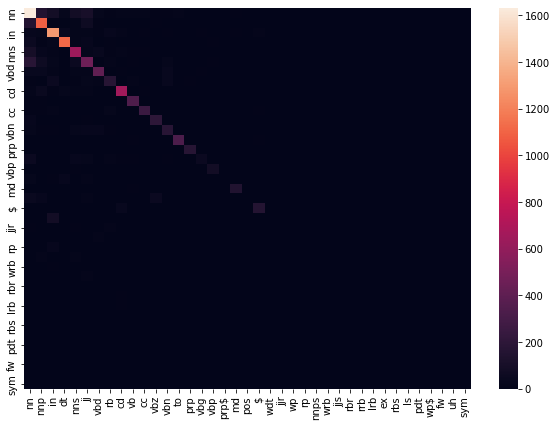

In [64]:
df_cm = pd.DataFrame(confusion_m, index = tag2idx.keys(),
                  columns = tag2idx.keys())
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=False)

In [79]:
from sklearn.metrics import f1_score

In [80]:
f1_score(y_test, y_pred_bool, labels=l)

ValueError: multiclass-multioutput is not supported

In [84]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report



print("MAJORITY")
# task as regression


r2_maj = r2_score(y_test, y_pred_bool)
mae_maj = mean_absolute_error(y_test, y_pred_bool)
mse_maj = mean_squared_error(y_test, y_pred_bool)

print("R2 score %f" % r2_maj)
# Mean Absolute Error
print("MAE %f" % mae_maj)
# Mean Squared Error
print("MSE %f" % mse_maj)
print()

# task as multiclass classification

report = classification_report(y_test.astype('int'), y_pred_bool.astype('int'), labels=l)
print(report)

confusion_m = confusion_matrix(y_test.astype('int'), y_pred_bool.astype('int'), labels=l)
print(confusion_m)
print()

# fancy confusion matrix
plot_confusion_matrix(baseline_model, x_test, y_test, normalize='true', cmap=plt.cm.Blues, values_format=".2f")

MAJORITY
R2 score -31.187319
MAE 3.283725
MSE 14.016530



ValueError: multiclass-multioutput is not supported

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as prfs

fig, plots = pyplot.subplots(3, sharex=True, figsize=(6, 6))
fig.suptitle('Regression comparison')
plots[0].bar(["maj","rnd","lr","sgd"], [r2_maj, r2_rnd, r2_lr, r2_sgd])
plots[0].set_title("R2")
plots[1].bar(["maj","rnd","lr","sgd"], [mae_maj, mae_rnd, mae_lr, mae_sgd])
plots[1].set_title("MAE")
plots[2].bar(["maj","rnd","lr","sgd"], [mse_maj, mse_rnd, mse_lr, mse_sgd])
plots[2].set_title("MSE")

pyplot.show()

prfs_maj = prfs(Y_test.astype('int'), Y_pred_test_maj.astype('int'), labels=[1,2,3,4,7,8,9,10], average="macro")
prfs_rnd = prfs(Y_test.astype('int'), Y_pred_test_rnd.astype('int'), labels=[1,2,3,4,7,8,9,10], average="macro")
prfs_lr = prfs(Y_test.astype('int'), Y_pred_test_lr.astype('int'), labels=[1,2,3,4,7,8,9,10], average="macro")
prfs_sgd = prfs(Y_test.astype('int'), Y_pred_test_sgd.astype('int'), labels=[1,2,3,4,7,8,9,10], average="macro")

fig2, plots = pyplot.subplots(1,3, sharey=True, figsize=(12, 6))
fig2.suptitle('Classification comparison')
plots[0].bar(["maj","rnd","lr","sgd"], [prfs_maj[0], prfs_rnd[0], prfs_lr[0], prfs_sgd[0]])
plots[0].set_title("prec")
plots[1].bar(["maj","rnd","lr","sgd"], [prfs_maj[1], prfs_rnd[1], prfs_lr[1], prfs_sgd[1]])
plots[1].set_title("rec")
plots[2].bar(["maj","rnd","lr","sgd"], [prfs_maj[2], prfs_rnd[2], prfs_lr[2], prfs_sgd[2]])
plots[2].set_title("macro f1")

pyplot.show()